This notebook shows the construction of simple feed-forward normalizing flows. 

In [1]:
from lib.toy_data import inf_train_gen
from lib.visualize_flow import plt_flow_2D
import matplotlib.pyplot as plt
from models import *
from timeit import default_timer as timer
import torch.nn as nn
import numpy as np
%matplotlib inline
import torchvision

In [2]:
batch_size_train = 100
batch_size_test = 100
n_epochs = 100
log_interval = 100

In [3]:
def logit(x, alpha=1E-6):
    y = alpha + (1.-2*alpha)*x
    return np.log(y) - np.log(1. - y)

def logit_back(x, alpha=1E-6):
    y = torch.sigmoid(x)
    return (y - alpha)/(1.-2*alpha)

class AddUniformNoise(object):
    def __init__(self, alpha=1E-6):
        self.alpha = alpha
    def __call__(self,samples):
        samples = np.array(samples,dtype = np.float32)
        samples += np.random.uniform(size = samples.shape)
        samples = logit(samples/256., self.alpha)
        return samples
class ToTensor(object):
    def __init__(self):
        pass
    def __call__(self,samples):
        samples = torch.from_numpy(samples).float()
        return samples

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               AddUniformNoise(),
                               ToTensor()
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               AddUniformNoise(),
                               ToTensor()
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [6]:
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
net = MNISTAugmentedFlow().to(dev)
opt = torch.optim.Adam(net.parameters(), 1e-3, weight_decay=1e-5)


5 14 14
5 7 7
1 3 3


In [7]:
def train(epoch):
    net.train()
    plt.figure()
    for batch_idx, (data, target) in enumerate(train_loader):
        opt.zero_grad()
        ll, z = net(data.view(-1, 1, 28, 28).to(dev))
        loss = -ll.mean()
        loss.backward()
        opt.step()
        if batch_idx % log_interval == 0:
            plt.subplot(2, 2, 1)
            x_gen = net.invert(torch.randn(1, z.shape[1]).to(dev))
            plt.imshow(x_gen.view(28, 28).detach().cpu().numpy())
            plt.subplot(2, 2, 2)
            plt.imshow(net.invert(z[[0], :]).view(28, 28).detach().cpu().numpy())
            plt.subplot(2, 2, 3)
            plt.imshow(logit_back(x_gen.view(28, 28)).detach().cpu().numpy())
            plt.subplot(2, 2, 4)
            plt.imshow(logit_back(net.invert(z[[0], :])).view(28, 28).detach().cpu().numpy())
            plt.show()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end="\r", flush=True)
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(net.state_dict(), 'model.pth')
            torch.save(opt.state_dict(), 'optimizer.pth')

In [8]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output, _ = net(data.view(-1, 1, 28, 28).to(dev))
            loss = output.mean()
            test_loss += loss.item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}\n'.format(test_loss))


Test set: Avg. loss: -30483.9207



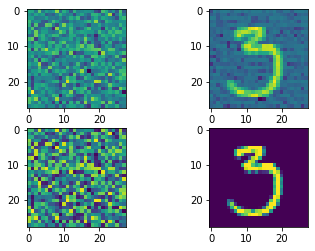

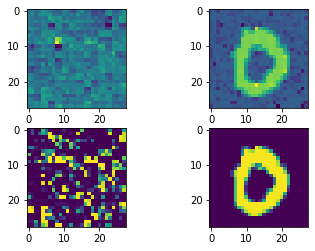

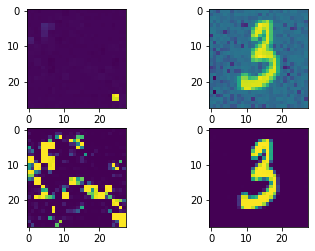

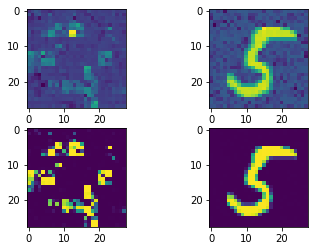

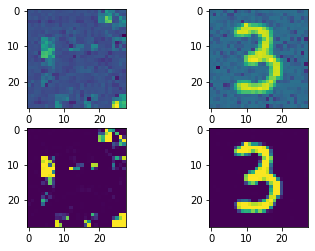

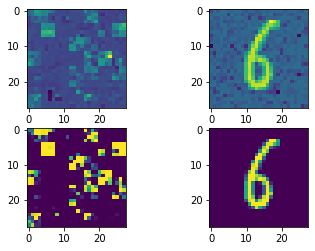

Train Epoch: 1 [50000/60000 (83%)]	Loss: -17744.966797
Test set: Avg. loss: 326.6565



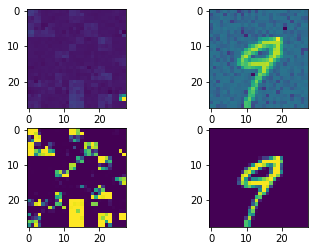

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()